In [2]:
import pandas as pd
from neo4j import GraphDatabase

uri = "neo4j://localhost:7687"
driver = GraphDatabase.driver(uri, auth=("neo4j", "password"))

stops = pd.read_csv("data/stops.txt")
trips = pd.read_csv("data/trips.txt")
stop_times = pd.read_csv("data/stop_times.txt")
routes = pd.read_csv("data/routes.txt")

C:\Users\balin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\balin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import numpy as np

# Which stops can be reached without switching rides?

In [1]:
def reachable_stops( depart_stop ):
    """
    Find all stops that has a matching substring with depart_stop
    and list all the reachable stops from them.
    """
    with driver.session() as session:

        response = session.run(f"""
        MATCH (s1: Stop)
        WHERE s1.stop_name CONTAINS "{depart_stop}"

        MATCH (s1)-[:STOPS_AT]-(t: Trip)-[:STOPS_AT]-(s2: Stop)
        RETURN DISTINCT s2.stop_name

        """)

        stop_names = [ record[0] for record in response]
    return stop_names


In [41]:
asd = reachable_stops("Móricz Zsigmond körtér")
len(asd)

439

# Which ride can be switched to from a given ride?

In [ ]:
# Pre-compute distances of stops which are close to each other


with driver.session() as session:
    session.run( \
"""MATCH (s1: Stop), (s2: Stop)

WITH point.distance(point( {x: s1.stop_lon, y: s1.stop_lat, crs: "WGS-84"}) ,
                    point( {x: s2.stop_lon, y: s2.stop_lat, crs: "WGS-84"})) as dist,
s1 as s1,
s2 as s2

WHERE dist < 600      //only create relationship between stops closer than 600m

MERGE (s1)-[:CLOSE_TO {d: dist}]-(s2)"""
)

- In ~99% (79.326 out of 6.441.309) of the time the arrival and departure time are the same. So I chose not to make distinct relationships for both.

- The preferred walking speed is 1.42 m/s, however only the aerial distance is available for now (the real distance is out of scope), so I chose the walking speed to be 1 m/s

- GTFS uses the WGS84 CRS, I used neo4j's spatial functions for calculating distance

In [8]:
def switch_from_ride(trip_id):
    with driver.session() as session:
        response = session.run( \
        """
MATCH (t1: Trip{trip_id : "%s"})
        MATCH (t1)-[st1:STOPS_AT]-(: Stop)-[cls:CLOSE_TO]-(s2: Stop)-[st2:STOPS_AT]-(t2: Trip)
        WHERE st1.arrival_time < st2.departure_time    //weaker condition, but it speeds up the calc a little


        WITH *, duration.inSeconds( st1.arrival_time, st2.departure_time ) as dur

        WHERE dur.seconds*1 > cls.d     // the stop must be in reachable distance
        and dur.seconds < 600          // make the switch in 10 minutes

        RETURN t2.trip_id, t2.route_id, s2.stop_name, dur.seconds
        """ % trip_id
            )

        rides = [{"trip_id": r[0], "route_id": r[1], "stop_name": r[2], "duration": r[3]} 
                    for r in response]
    
    return rides

In [9]:
trips[  (trips.service_id == "B99619APPMAA-011") & (trips.route_id == "1530") ]

,route_id,trip_id,service_id,trip_headsign,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed,boarding_door


In [10]:
q = switch_from_ride("C413899203")
len(q)

2814

In [5]:
stop_times[ stop_times.arrival_time != stop_times.departure_time].shape

(79326, 9)

# Plan possible routes between stops at a given time of day

In [4]:
MATCH (sd: SDate {service_date: date("2022-01-21")})-[*1]-(services)
MATCH (t1: Trip{route_id : "1530"})-[:OPERATES]-(services)
MATCH (t2: Trip)-[:OPERATES]-(services)

MATCH path = (:Stop{stop_name: "Szent Imre Kórház"})-[st1:STOPS_AT]-(t1)-[:STOPS_AT*0..1]-(t2)- [st2:STOPS_AT]-(:Stop{stop_name: "Petőfi híd, budai hídfő"})

WHERE time("08:00:00") <=st1.arrival_time <= time("09:00:00")
AND   time("08:00:00") <=st2.arrival_time <= time("09:00:00")
AND st1.stop_sequence < st2.stop_sequence

RETURN path

(79326, 9)

In [1]:
MATCH (sd: SDate {service_date: date("2022-01-21")})-[*1]-(services)
MATCH (t: Trip)-[:OPERATES]-(services)

MATCH path = (:Stop{stop_name: "Szent Imre Kórház"})-[st1:STOPS_AT]-(t)-[:STOPS_AT*0..1]-(t)- [st2:STOPS_AT]-(:Stop{stop_name: "Petőfi híd, budai hídfő"})

WHERE all( rel in relationships(path) WHERE 
            ( type(rel)="CLOSE_TO" or 
            ( time("08:00:00") <=rel.arrival_time <= time("09:00:00")) )
         )
AND st1.stop_sequence < st2.stop_sequence

RETURN path

0.012315198665364447

In [ ]:
MATCH (sd: SDate {service_date: date("2022-01-21")})-[*1]-(services)
MATCH (t: Trip)-[:OPERATES]-(services)

MATCH path = (:Stop{stop_name: "Szent Imre Kórház"})-[st1:STOPS_AT]-(t)-[:STOPS_AT*0..1]-(t)- [st2:STOPS_AT]-(:Stop{stop_name: "Petőfi híd, budai hídfő"})

WHERE all( rel in relationships(path) WHERE 
            ( type(rel)="CLOSE_TO" or 
            ( time("08:00:00") <=rel.arrival_time <= time("09:00:00")) )
         )
AND st1.stop_sequence < st2.stop_sequence

WITH relationships(path) as rels

//UNWIND rels as rel
//RETURN COLLECT(rel.arrival_time)
WITH [ rel in rels | rel.arrival_time ] as arrtimes
RETURN apoc.coll.sort(arrtimes) = arrtimes

In [ ]:
MATCH (sd: SDate {service_date: date("2022-01-21")})-[*1]-(service_nodes)
WITH [ serv in COLLECT(service_nodes) | serv.service_id ] as services
//WHERE st.arrival_time < time("10:00:00")
//AND st.arrival_time > time("06:00:00")

MATCH path = (:Stop{stop_name: "Szent Imre Kórház"})-[:STOPS_AT]-(t1: Trip)-[:STOPS_AT|CLOSE_TO*0..3]-(t2: Trip)- [:STOPS_AT]-(:Stop{stop_name: "Petőfi híd, budai hídfő"})

WHERE all( n in nodes(path) WHERE
            ( labels(n)<>["Trip"] or 
              (n.service_id in services))
          )


WITH *, relationships(path) as rels
WHERE all( rel in rels WHERE 
            ( type(rel)="CLOSE_TO" or 
            ( time("08:00:00") <=rel.arrival_time <= time("09:00:00")) )
         )

WITH *, [ rel in rels | rel.arrival_time ] as arrtimes
//WHERE apoc.coll.sort(arrtimes) = arrtimes  // check if trip goes in preferred direction
RETURN path

# Ways to describe the topology of the transportation network

### Degree centrality

In [90]:
def stop_degree_centrality():

    with driver.session() as session:
            response = session.run( \
            """
            MATCH (s: Stop)-[:STOPS_AT*2]-(other_stops)
            RETURN s.stop_name, COUNT(DISTINCT other_stops)
            """ 
                )

            rides = [ r[1]
                        for r in response]
    
    return np.array( rides )

def stop_trip_degree_centrality():

    with driver.session() as session:
            response = session.run( \
            """
            MATCH (s: Stop)-[:STOPS_AT*1]-(trips)
            RETURN s.stop_name, COUNT(DISTINCT trips)
            """ 
                )

            rides = [ r[1]
                        for r in response]
    
    return np.array( rides )

def stop_route_degree_centrality():

    with driver.session() as session:
            response = session.run( \
            """
            MATCH (s: Stop)-[:STOPS_AT*1]-(trips)
            RETURN s.stop_name, COUNT(DISTINCT trips.route_id)
            """ 
                )

            rides = [ r[1]
                        for r in response]
    
    return np.array( rides )

In [104]:
stop_deg = stop_trip_degree_centrality()

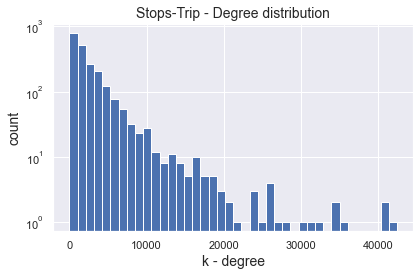

In [105]:
#count, bins= np.histogram(stop_deg, bins = 40)
plt.hist(stop_deg, bins = 40)
#plt.plot(bins[1:], count, marker = "o")

plt.yscale("log")
plt.xlabel("k - degree", size= 14)
plt.ylabel("count", size = 14)
plt.title("Stops-Trip - Degree distribution", size = 14)
plt.tight_layout()
plt.savefig("media/s-t_deg_centr.svg")


### Assortativity

In [73]:
MATCH (s: Stop)-[:STOPS_AT*2]-(other_stops)-[:STOPS_AT*2]-(other_stops2)
RETURN s, COUNT(DISTINCT other_stops), COUNT(DISTINCT other_stops2)

SyntaxError: invalid syntax (<ipython-input-73-81bebf248dc3>, line 1)